# Evaluation of the training

## Confusion matrices, discriminator shapes, ROC curves

In [1]:
import uproot4 as uproot
import numpy as np
import awkward1 as ak

import matplotlib.pyplot as plt
import mplhep as hep

import torch
import torch.nn as nn

from sklearn import metrics

import gc

import coffea.hist as hist


In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


#This is just some plot styling
plt.style.use(hep.cms.style.ROOT)
C = ['firebrick', 'darkgreen', 'darkblue', 'grey', 'cyan','magenta']
colorcode = ['firebrick','magenta','cyan','darkgreen']
path = 'Figures/'

In [4]:
test_input_file_paths = ['/hpcwork/um106329/new_march_21/scaled/test_inputs_%d.pt' % k for k in range(0,10)]


test_inputs = torch.cat(tuple(torch.load(ti) for ti in test_input_file_paths)).float()
print('test inputs done')
len_test = len(test_inputs)
print('number of test inputs', len_test)

test_target_file_paths = ['/hpcwork/um106329/new_march_21/scaled/test_targets_%d.pt' % k for k in range(0,10)]
DeepCSV_testset_file_paths = ['/hpcwork/um106329/new_march_21/scaled/DeepCSV_testset_%d.pt' % k for k in range(0,10)]

test_targets = torch.cat(tuple(torch.load(ti) for ti in test_target_file_paths)).float()
print('test targets done')
DeepCSV_testset = np.concatenate([torch.load(ti) for ti in DeepCSV_testset_file_paths])
print('DeepCSV test done')

test inputs done
number of test inputs 10030144
test targets done
DeepCSV test done


In [18]:
at_epoch = 23

NUM_DATASETS = 42




criterion = nn.CrossEntropyLoss()



model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{at_epoch}_epochs_v9_GPU_weighted_new_{NUM_DATASETS}_datasets.pt', map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

In [19]:
#evaluate network on inputs
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.numpy()
print('predictions done')

jetFlavour = test_targets+1

predictions done


In [20]:
np.unique(test_targets.numpy())

array([0., 1., 2., 3.], dtype=float32)

In [21]:
mostprob = torch.argmax(predsTensor, 1)

In [22]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets, mostprob)
cfm

array([[      0,       0,       0,  252811],
       [      0,       0,       0,   47101],
       [      0,       0,       0,  671106],
       [      0,       0,       0, 9059126]])

Text(0.5, 0.98, 'Classifier (loss weighting) and DeepCSV outputs\n After 23 epochs, evaluated on 10030144 jets')

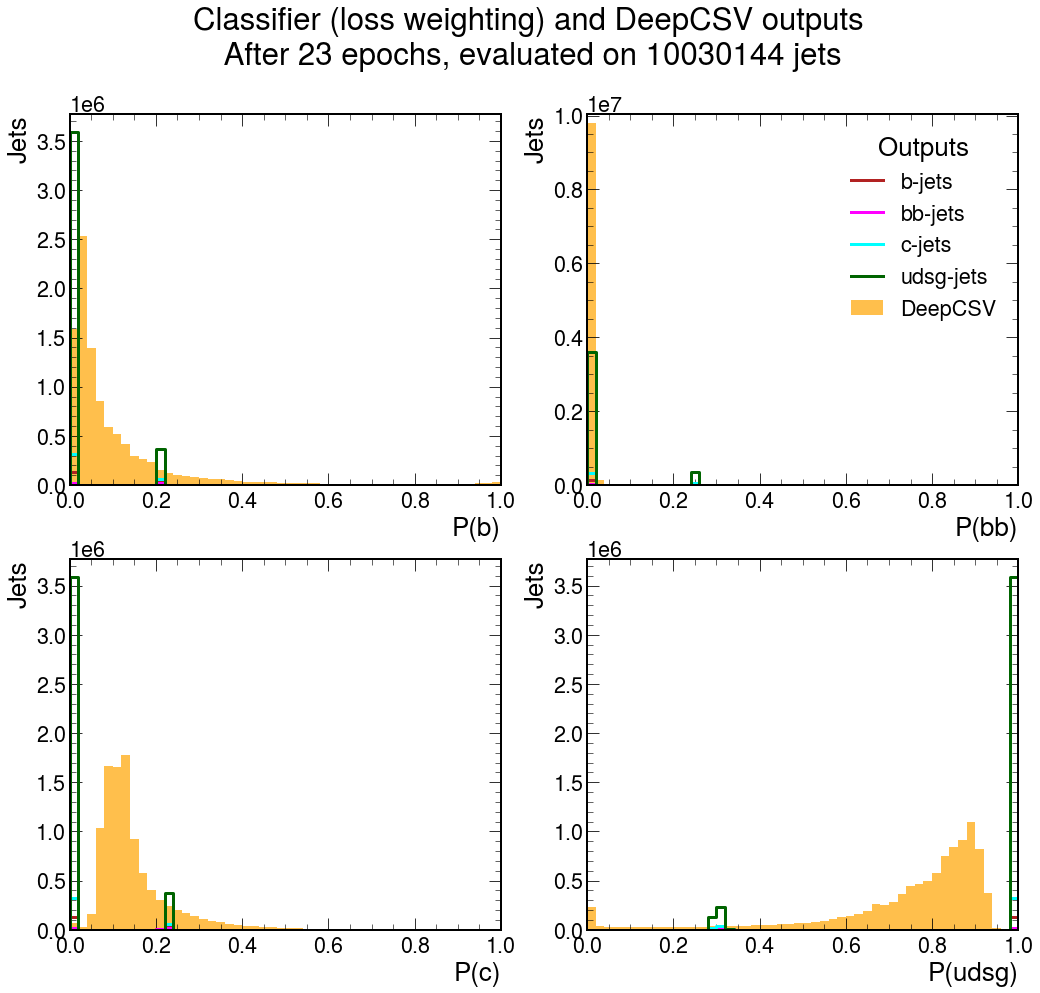

In [23]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (loss weighting) and DeepCSV outputs\n After {at_epoch} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.6093803826177026
auc for bb-tagging: 0.8024518570983812
auc for c-tagging: 0.5718542063915699
auc for udsg-tagging: 0.6012712495232968


22075

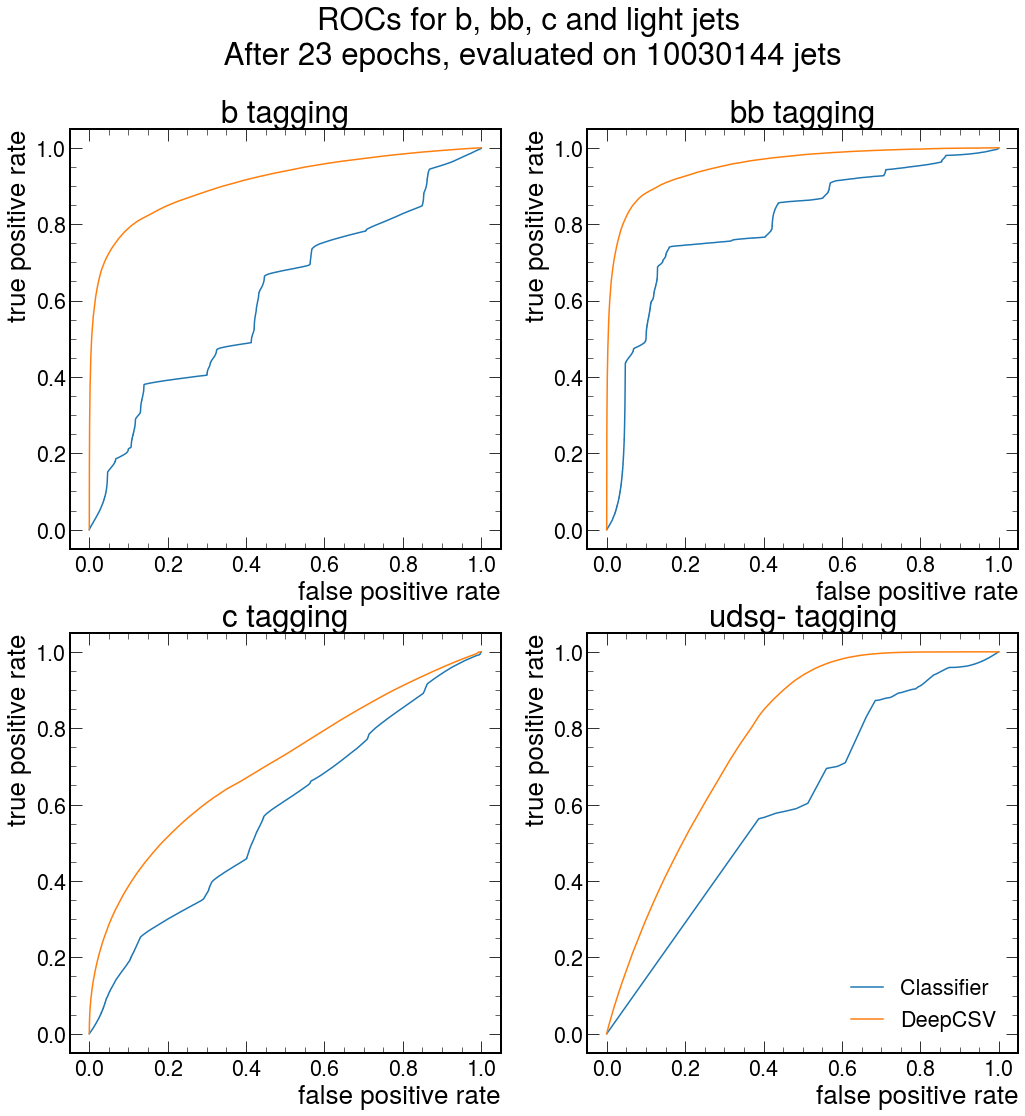

In [24]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets\n After {at_epoch} epochs, evaluated on {len_test} jets')
gc.collect()

In [3]:
at_epoch = 50

NUM_DATASETS = 42




criterion = nn.CrossEntropyLoss()



model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{at_epoch}_epochs_v6_GPU_weighted_as_is_{NUM_DATASETS}_datasets.pt', map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

In [5]:
#evaluate network on inputs
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.numpy()
print('predictions done')

jetFlavour = test_targets+1

predictions done


In [6]:
np.unique(test_targets.numpy())

array([0., 1., 2., 3.], dtype=float32)

In [7]:
mostprob = torch.argmax(predsTensor, 1)

In [8]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets, mostprob)
cfm

array([[      0,       0,       0,  252811],
       [      0,       0,       0,   47101],
       [      0,       0,       0,  671106],
       [      0,       0,       0, 9059126]])

Text(0.5, 0.98, 'Classifier and DeepCSV outputs\n After 50 epochs, evaluated on 10030144 jets')

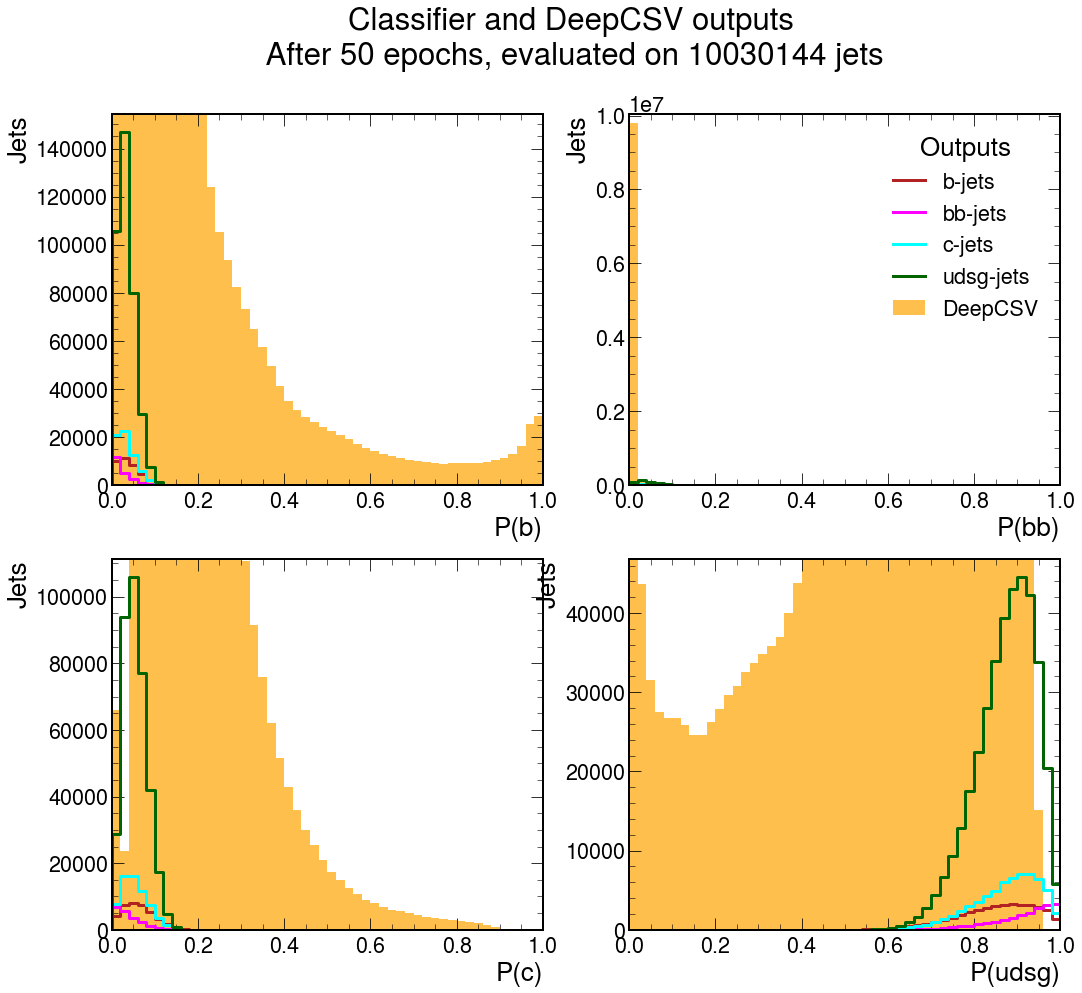

In [9]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier and DeepCSV outputs\n After {at_epoch} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.4065924495616378
auc for bb-tagging: 0.6174635310614648
auc for c-tagging: 0.5034969696866323
auc for udsg-tagging: 0.5424765573632673


1328

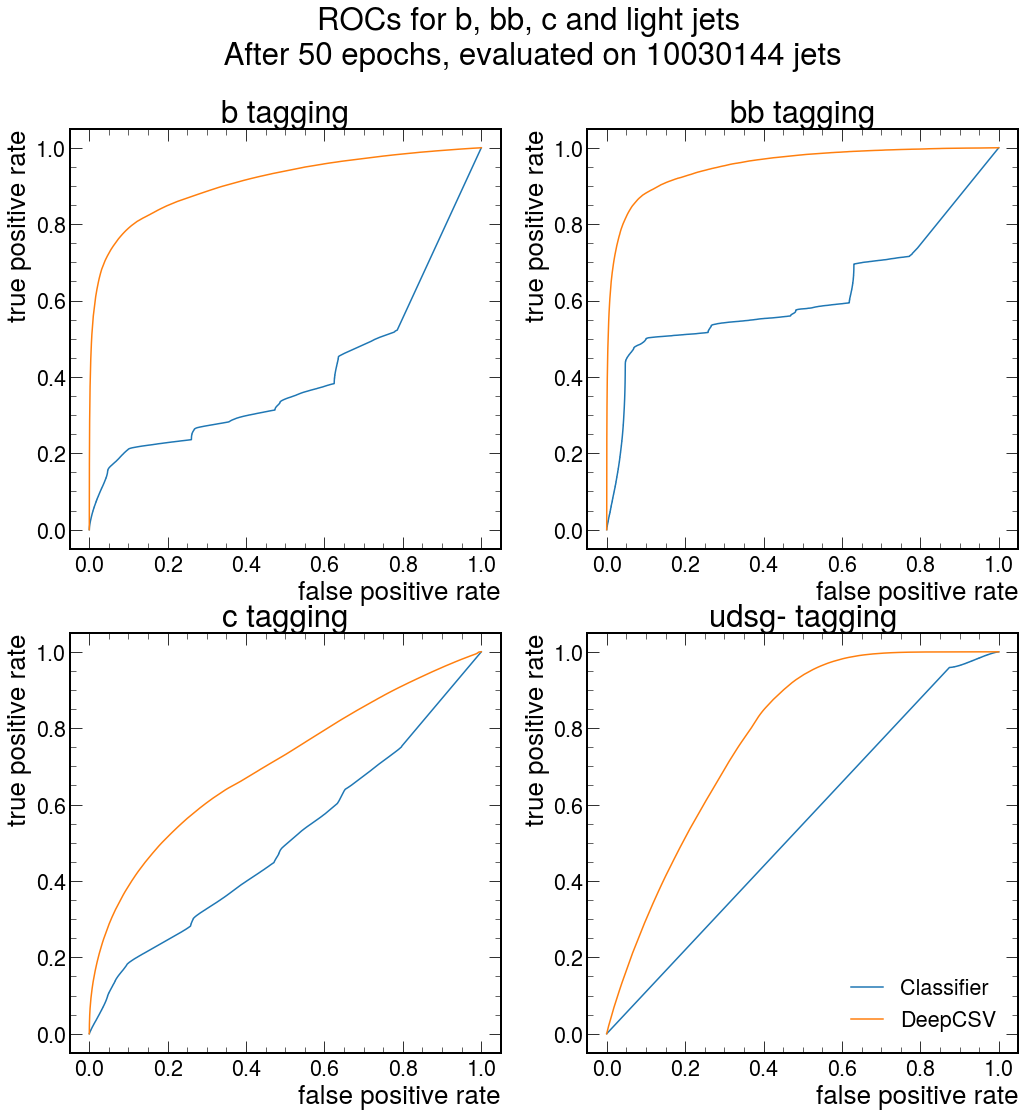

In [10]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets\n After {at_epoch} epochs, evaluated on {len_test} jets')
gc.collect()

Text(0.5, 0.98, 'Classifier and DeepCSV outputs\n After 40 epochs, evaluated on 28570333 jets')

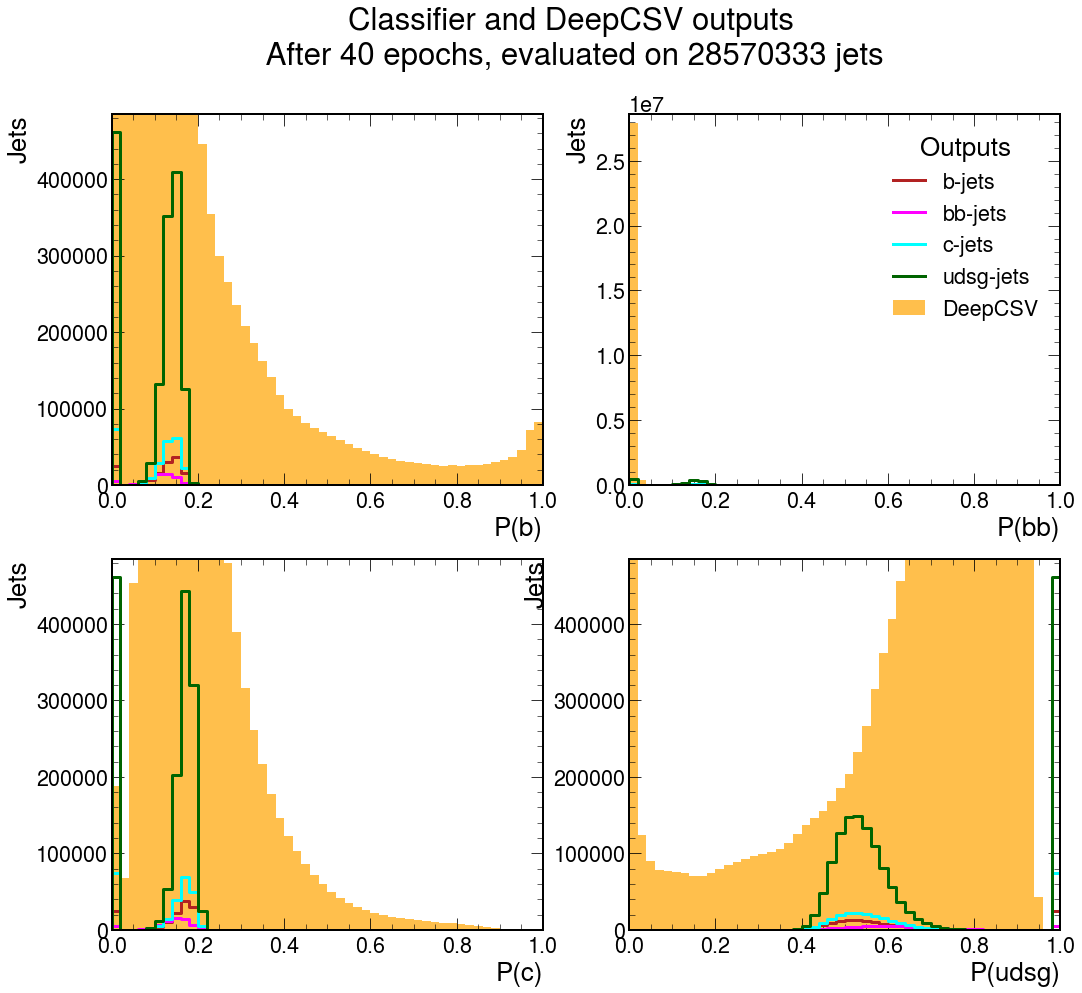

In [19]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier and DeepCSV outputs\n After {at_epoch} epochs, evaluated on {len_test} jets')


In [20]:
at_epoch = 20

NUM_DATASETS = 42




criterion = nn.CrossEntropyLoss()



model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{at_epoch}_epochs_v6_GPU_weighted_as_is_{NUM_DATASETS}_datasets.pt', map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

In [21]:
#evaluate network on inputs
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.numpy()
print('predictions done')

jetFlavour = test_targets+1

predictions done


In [22]:
np.unique(test_targets.numpy())

array([0., 1., 2., 3.], dtype=float32)

In [23]:
mostprob = torch.argmax(predsTensor, 1)

In [24]:
cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm

array([[       0,        0,        0,        0],
       [       0,        0,        0,        0],
       [       0,        0,        0,        0],
       [  720767,   134122,  1912214, 25803230]])

Text(0.5, 0.98, 'Classifier and DeepCSV outputs\n After 20 epochs, evaluated on 28570333 jets')

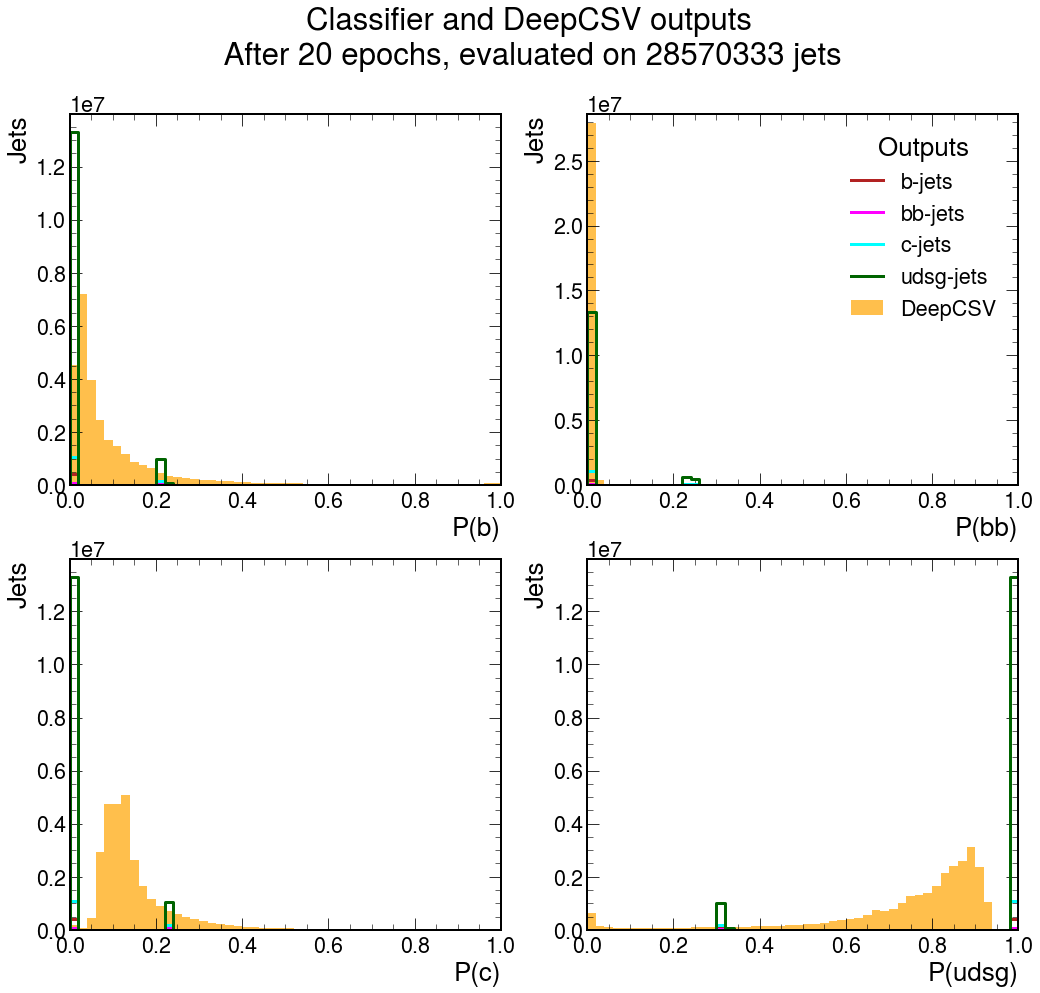

In [25]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier and DeepCSV outputs\n After {at_epoch} epochs, evaluated on {len_test} jets')


In [11]:
at_epoch = 100

NUM_DATASETS = 10




criterion = nn.CrossEntropyLoss()



model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{at_epoch}_epochs_v6_GPU_weighted_as_is_{NUM_DATASETS}_datasets.pt', map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

In [12]:
#evaluate network on inputs
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.numpy()
print('predictions done')

jetFlavour = test_targets+1

predictions done


In [13]:
np.unique(test_targets.numpy())

array([0., 1., 2., 3.], dtype=float32)

In [14]:
mostprob = torch.argmax(predsTensor, 1)

In [15]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets, mostprob)
cfm

array([[      0,       0,       0,  252811],
       [      0,       0,       0,   47101],
       [      0,       0,       0,  671106],
       [      0,       0,       0, 9059126]])

Text(0.5, 0.98, 'Classifier and DeepCSV outputs\n After 100 epochs, evaluated on 10030144 jets')

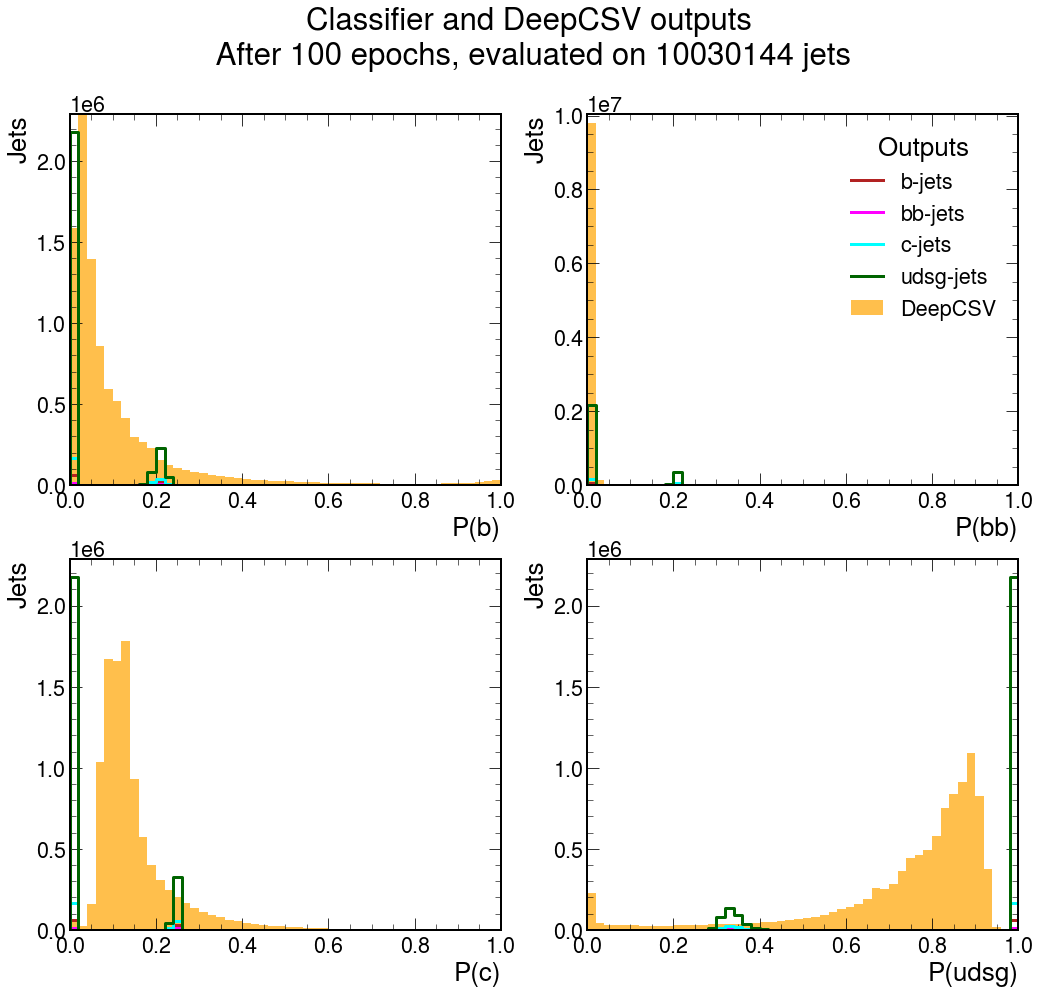

In [16]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier and DeepCSV outputs\n After {at_epoch} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.4978915946515183
auc for bb-tagging: 0.7420411630678602
auc for c-tagging: 0.5355632196276865
auc for udsg-tagging: 0.5574700634803245


22060

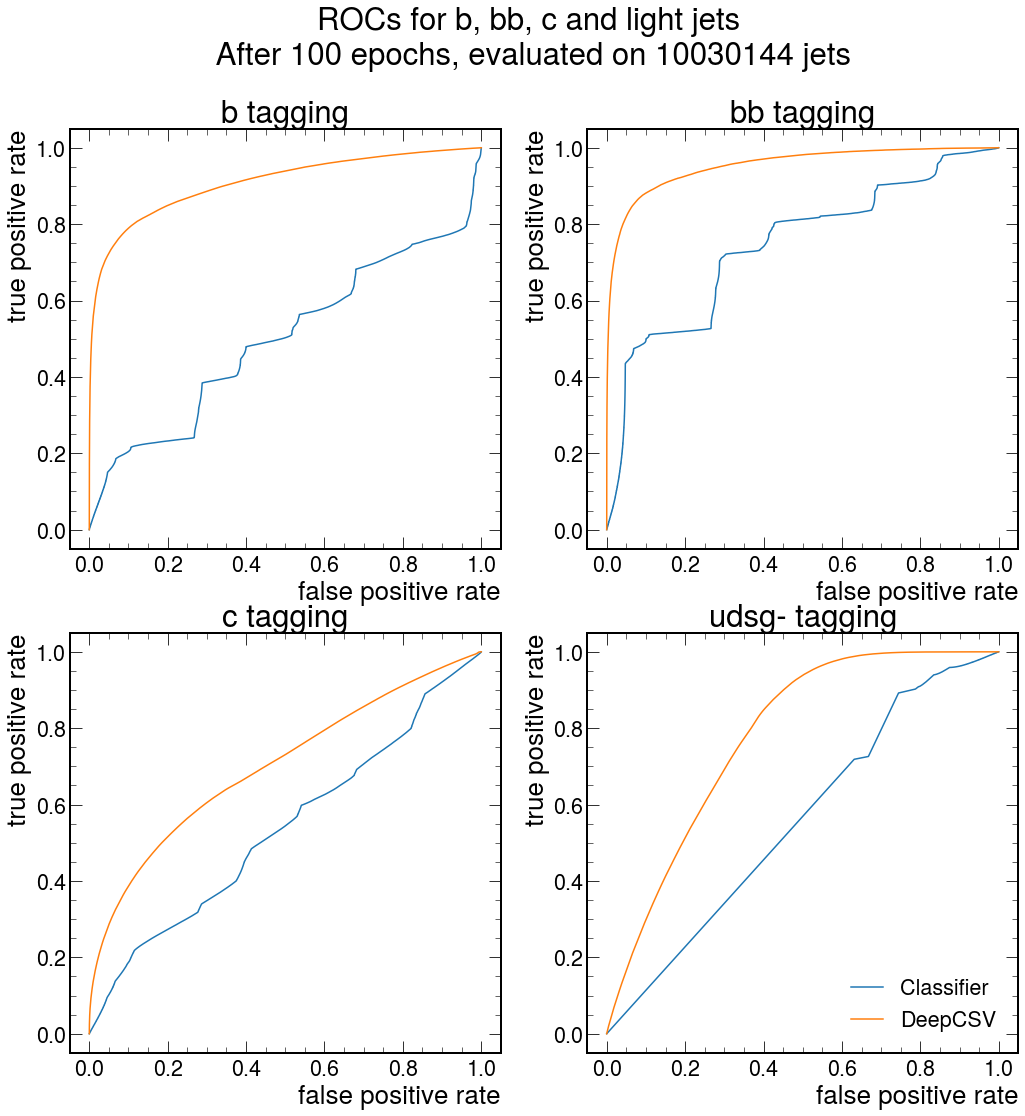

In [17]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets\n After {at_epoch} epochs, evaluated on {len_test} jets')
gc.collect()